# Dinamično načrtovanje filtrov za odstranjevanje višjih harmonikov

Ta zvezek:
- zazna osnovno frekvenco *f₀* (več metod) ali sprejme ročno vrednost,
- odstrani izbrane višje harmonike **nad 500 Hz** na dva načina (oba IIR):
  1. **Glavnični (comb) filter** z **Yule–Walker** zasnovo (±50 Hz okno),
  2. **Kaskada fiksno-rednih pasovnih zapor** (Butter/Cheby1/Cheby2/Elliptic, ±10 Hz),
- uporabi filtre na **vseh posnetkih** v mapi `/audio_data`,
- izriše **FFT pred/po filtriranju** in **odziv filtrov**,
- zapiše **f₀** za vsak signal (za zagovor),
- ter eksperimentalno odgovori na:
  1. Odvisnost frekvenčne učinkovitosti od **reda filtra**,
  2. Prednost **kaskade** proti enemu filtru,
  3. Primerjavo kaskade z **filtriranjem v frekvenčnem prostoru**.


In [9]:
# Core imports
from __future__ import annotations

import os
import json
import math
import warnings
from dataclasses import dataclass
from typing import List, Tuple, Dict, Iterable, Optional

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from scipy.signal import find_peaks

# Optional (Yule–Walker); robust fallback provided
try:
    from statsmodels.regression.linear_model import yule_walker
    HAVE_SM = True
except Exception:
    HAVE_SM = False
    warnings.warn("statsmodels not available; Yule–Walker notch will fall back to analytic notch.")

# Paths (adjust if needed)
AUDIO_DIR = "audio_data"
OUT_DIR   = os.path.join(AUDIO_DIR, "processed")
os.makedirs(OUT_DIR, exist_ok=True)

# Plot style (neutral & readable)
plt.rcParams.update({"figure.figsize": (8,5), "axes.grid": True})

def list_wavs(folder: str) -> List[str]:
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(".wav")]

def read_wav_mono(path: str) -> Tuple[int, np.ndarray]:
    fs, data = wavfile.read(path)
    if np.issubdtype(data.dtype, np.integer):
        data = data.astype(np.float64) / np.iinfo(data.dtype).max
    else:
        data = data.astype(np.float64)
    if data.ndim > 1:
        data = data.mean(axis=1)
    return fs, data

def write_wav_int16(path: str, fs: int, x: np.ndarray) -> None:
    wavfile.write(path, fs, np.int16(np.clip(x, -1, 1) * 32767))


/var/folders/64/6wxk92sj3px37_tfkmrktpf40000gq/T/ipykernel_27592/1481111491.py:23: UserWarning: statsmodels not available; Yule–Walker notch will fall back to analytic notch.
  warnings.warn("statsmodels not available; Yule–Walker notch will fall back to analytic notch.")


## Ocena osnovne frekvence *f₀*

Podprte metode:
- **autocorr**: največji vrh avtorelacijske funkcije (robustno za glas),
- **fft_peak**: največji vrh magnitude FFT (hiter približek),
- **cepstrum**: vrh v realnem cepstrumu,
- **peaks**: `scipy.find_peaks` po spektru s pragom.

Privzeto: `method="autocorr"`. Možna ročna vrednost `manual_f0_hz`.


In [10]:
def f0_autocorr(x: np.ndarray, fs: int, fmin=50.0, fmax=1500.0) -> float:
    x = x - np.mean(x)
    n = len(x)
    nfft = 1 << (2 * n - 1).bit_length()
    ps = np.abs(np.fft.rfft(x, nfft)) ** 2
    ac = np.fft.irfft(ps, nfft)[:n]
    ac = ac / (ac[0] + 1e-12)
    lag_min = int(fs / fmax)
    lag_max = int(fs / fmin)
    if lag_max <= lag_min + 1:
        lag_max = lag_min + 2
    peaks, _ = find_peaks(ac[lag_min:lag_max])
    if len(peaks) == 0:
        raise RuntimeError("Ni ustreznega vrha v avtorelacijski funkciji.")
    k = peaks[np.argmax(ac[lag_min:lag_max][peaks])] + lag_min
    return fs / k


def estimate_f0(x: np.ndarray, fs: int, manual_f0_hz: Optional[float] = None) -> float:
    if manual_f0_hz is not None and manual_f0_hz > 0:
        return float(manual_f0_hz)
    method = method.lower()
    return f0_autocorr(x, fs)


## Načrtovanje filtrov

- **Glavnični (comb) – Yule–Walker**: za vsak izbran harmonik `k∙f₀` naredimo
  **notch** ±50 Hz. Če Yule–Walker odpove, uporabimo **analitični** 2. reda notch.
- **Kaskada pasovnih zapor (IIR)**: za vsak harmonik naredimo **bandstop**
  ±10 Hz, **fiksni red** `N` za vsak odsek, poljubna družina
  (*butter*, *cheby1*, *cheby2*, *ellip*). Uporabimo **SOS** in `sosfiltfilt`.


In [11]:
def analytic_notch_tf(fs: int, f0: float, bw_hz: float = 100.0) -> Tuple[np.ndarray, np.ndarray]:
    # 2nd-order notch, approx 3-dB BW ~ bw_hz
    w0 = 2*np.pi*f0/fs
    r = 1 - (np.pi * bw_hz) / fs
    r = np.clip(r, 0.0, 0.9999)  # stability
    b = np.array([1, -2*np.cos(w0), 1], dtype=float)
    a = np.array([1, -2*r*np.cos(w0), r**2], dtype=float)
    return b, a

def yule_walker_notch_tf(fs: int, f0: float, bw_hz: float = 100.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Try to obtain an AR(2) that shapes a notch near f0 using Yule–Walker.
    Fall back to analytic notch on failure or when statsmodels unavailable.
    """
    if not HAVE_SM:
        return analytic_notch_tf(fs, f0, bw_hz)
    n = 2048
    t = np.arange(n)/fs
    impulse = np.zeros(n); impulse[0] = 1.0
    # enforce a zero at f0 in synthetic target
    impulse -= np.cos(2*np.pi*f0*t)
    try:
        rho, sigma2 = yule_walker(impulse, order=2, method="mle")
        a = np.r_[1.0, -rho]  # statsmodels sign convention
        b = np.array([1, -2*np.cos(2*np.pi*f0/fs), 1], dtype=float)
    except Exception as e:
        warnings.warn(f"Yule–Walker ni uspel ({e}); uporaba analitičnega notcha.")
        b, a = analytic_notch_tf(fs, f0, bw_hz)
    return b, a

def design_comb_cascade_sos(fs: int, f0: float, harmonics: Iterable[int],
                            bw_hz: float = 100.0) -> np.ndarray:
    """
    Cascade of 2nd-order notches (one per harmonic) using Yule–Walker TF (fallback to analytic).
    Only harmonics > 500 Hz kept.
    """
    sos_list = []
    for k in harmonics:
        fc = k * f0
        if fc <= 500.0:
            continue
        b, a = yule_walker_notch_tf(fs, fc, bw_hz=bw_hz)
        sos_list.append(signal.tf2sos(b, a))
    if len(sos_list) == 0:
        raise RuntimeError("Ni harmonikov nad 500 Hz za filtriranje.")
    return np.vstack(sos_list)


In [29]:
from typing import Iterable
import numpy as np
from scipy import signal

def design_bandstop_section_butter(fs: int, f_center: float, half_bw_hz: float, order: int = 4) -> np.ndarray:
    """
    Single Butterworth bandstop (SOS) centered at f_center with ±half_bw_hz.
    """
    nyq = fs * 0.5
    # guard band + normalize
    lo_hz = max(1.0, f_center - half_bw_hz)
    hi_hz = min(nyq - 1.0, f_center + half_bw_hz)
    low = lo_hz / nyq
    high = hi_hz / nyq
    if not (0 < low < high < 1):
        raise ValueError(f"Neveljaven pas: [{lo_hz:.2f}, {hi_hz:.2f}] Hz pri fs={fs}.")
    return signal.iirfilter(order, [low, high], btype="bandstop", ftype="butter", output="sos")

def design_bandstop_cascade_sos_simple(fs: int, f0: float, harmonics: Iterable[int],
                                       half_bw_hz: float = 10.0, order: int = 4) -> np.ndarray:
    """
    Cascade of fixed-order Butterworth bandstops (±half_bw_hz) for harmonics > 500 Hz and < Nyquist.
    Returns a single SOS array ready for sosfilt/filtfilt.
    """
    sos_list = []
    nyq = fs * 0.5
    for k in sorted(set(harmonics)):
        fc = k * f0
        if fc <= 500.0 or fc >= nyq - 1.0:
            continue
        sos = design_bandstop_section_butter(fs, fc, half_bw_hz, order=order)
        sos_list.append(sos)
    if not sos_list:
        raise RuntimeError("Ni harmonikov nad 500 Hz (in pod Nyquist) za filtriranje.")
    return np.vstack(sos_list)


In [13]:
def apply_sos_zero_phase(x: np.ndarray, sos: np.ndarray) -> np.ndarray:
    # Zero-phase to avoid phase distortion; careful with short signals
    return signal.sosfiltfilt(sos, x, padlen=3*max(1, sos.shape[0])*10)

def freq_response_sos(sos: np.ndarray, fs: int, worN: int = 4096) -> Tuple[np.ndarray, np.ndarray]:
    w, h = signal.sosfreqz(sos, worN=worN, fs=fs)
    return w, h

def plot_filter_response(w_hz: np.ndarray, H: np.ndarray, title: str, ylim_db: Tuple[float,float]=(-80,5)) -> None:
    plt.figure()
    plt.semilogx(w_hz, 20*np.log10(np.maximum(np.abs(H), 1e-12)))
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.ylim(*ylim_db)
    plt.grid(True, which="both")
    plt.tight_layout()
    plt.show()

def plot_fft(signal_time: np.ndarray, fs: int, title: str, fmax: Optional[float] = None) -> None:
    n = len(signal_time)
    nfft = 1 << (n - 1).bit_length()
    X = np.fft.rfft(signal_time * np.hanning(n), nfft)
    freqs = np.fft.rfftfreq(nfft, 1/fs)
    if fmax is None: fmax = fs/2
    mask = freqs <= fmax
    plt.figure()
    plt.plot(freqs[mask], np.abs(X[mask])/n)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def overlay_fft(orig: np.ndarray, filt: np.ndarray, fs: int, title: str, fmax: Optional[float]=None) -> None:
    n = max(len(orig), len(filt))
    nfft = 1 << (n - 1).bit_length()
    freqs = np.fft.rfftfreq(nfft, 1/fs)
    Xo = np.fft.rfft(orig * np.hanning(len(orig)), nfft)
    Xf = np.fft.rfft(filt * np.hanning(len(filt)), nfft)
    if fmax is None: fmax = fs/2
    mask = freqs <= fmax
    plt.figure()
    plt.plot(freqs[mask], np.abs(Xo[mask])/len(orig), label="Original")
    plt.plot(freqs[mask], np.abs(Xf[mask])/len(filt), label="Filtered")
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Zagon po celotni mapi `/audio_data`

Parametri:
- `harmonics_to_remove`: npr. `[2, 3, 6]`
- `f0_method`: `"autocorr" | "fft_peak" | "cepstrum" | "peaks"`
- `manual_f0_hz`: `None` (avtomatsko) ali npr. `120.0`
- IIR kaskada: `family`, `order` (fiksno število), ±**10 Hz**
- Comb/Yule–Walker: ±**50 Hz**

Zapis:
- Shrani WAV datoteke + JSON dnevnik f₀ in parametrov v `/audio_data/processed/`.
- Za vsako datoteko: FFT pred/po in odzivi filtrov.


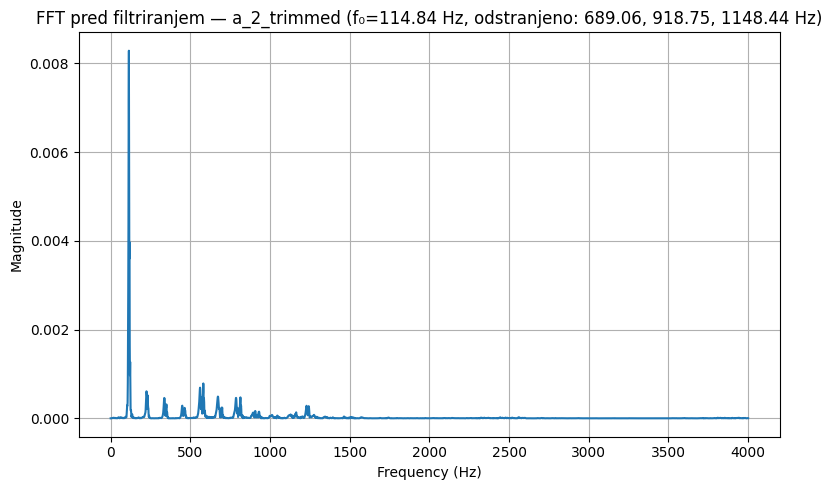

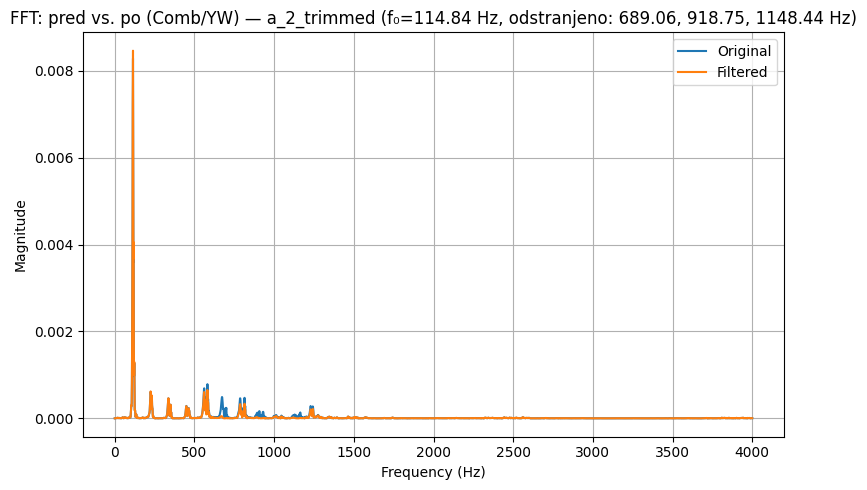

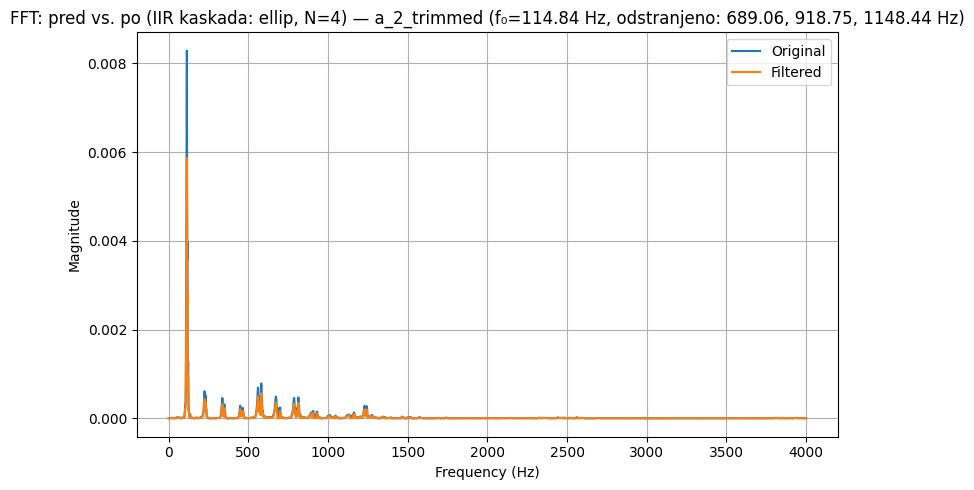

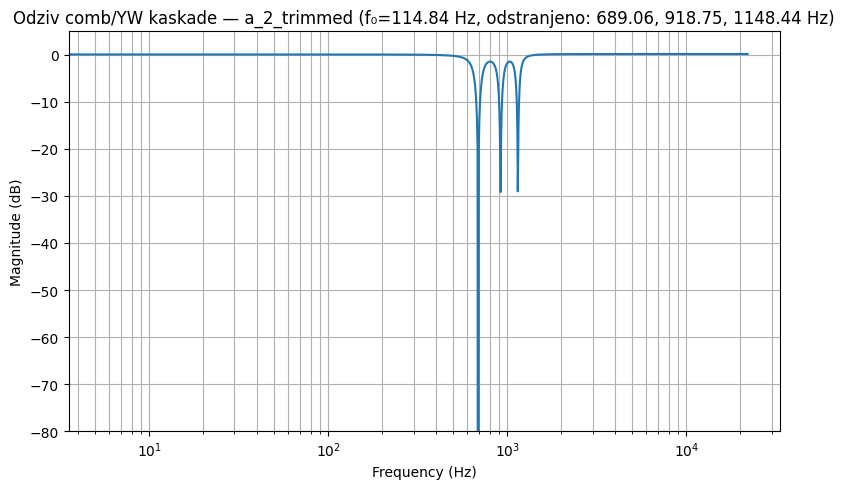

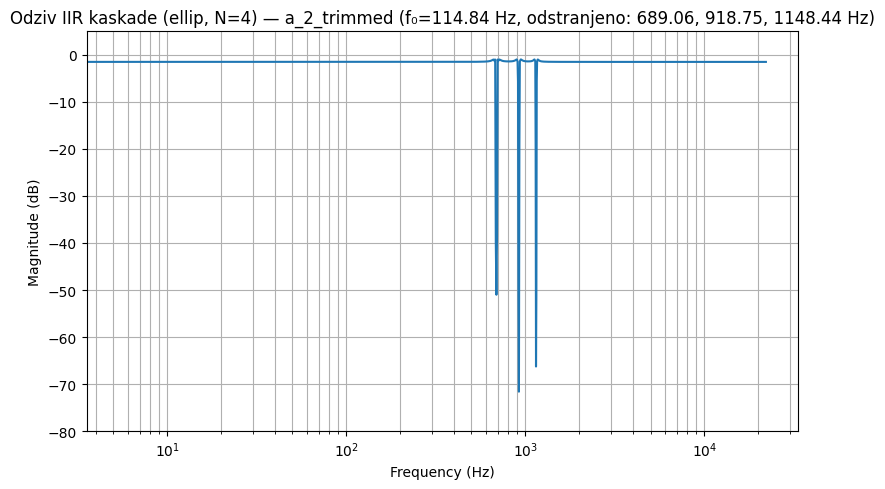

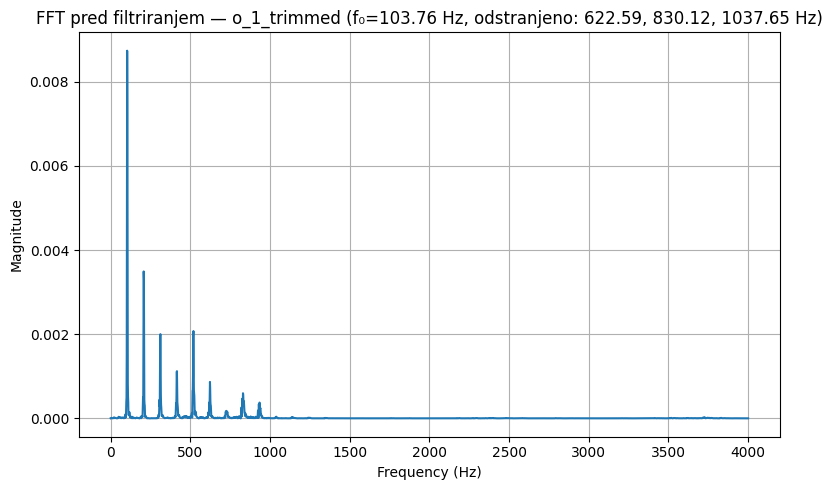

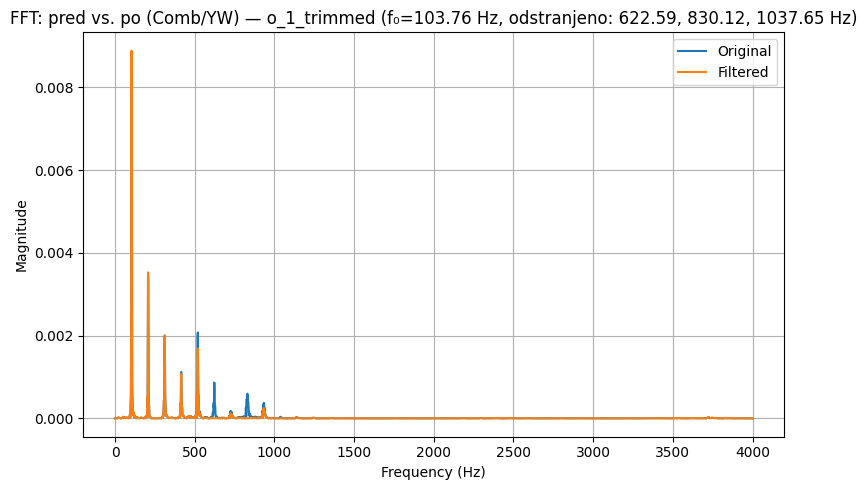

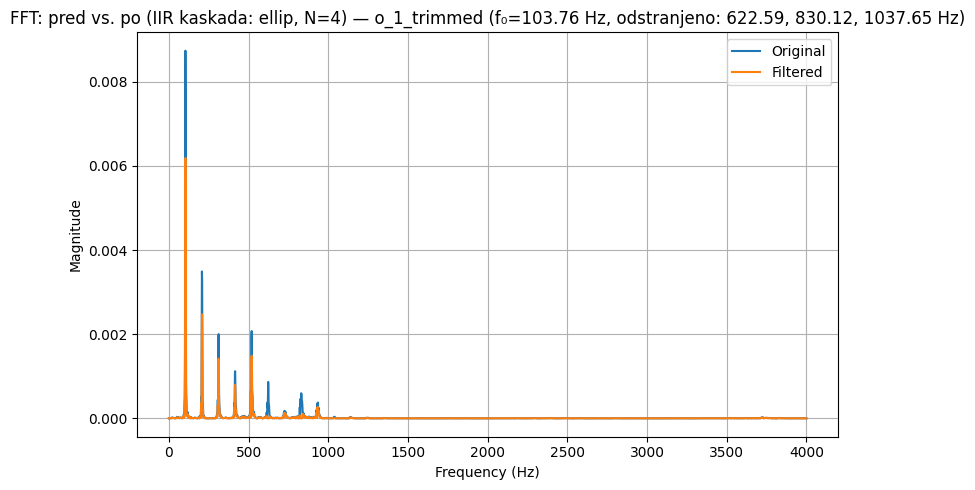

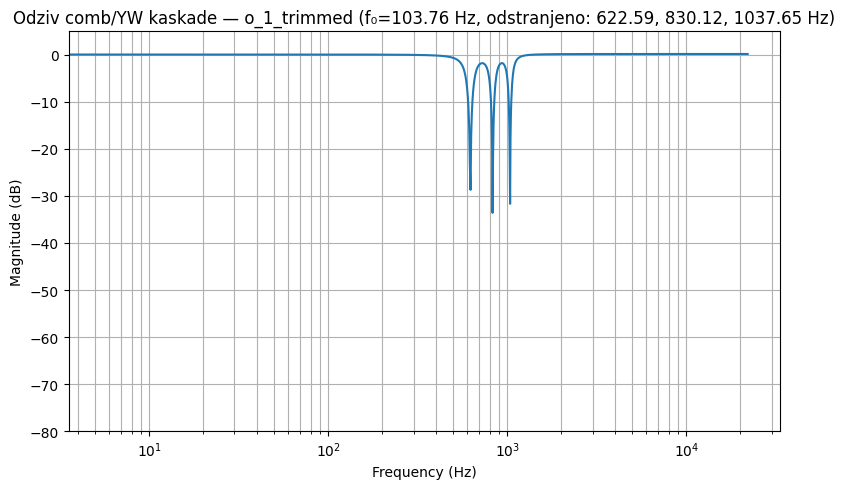

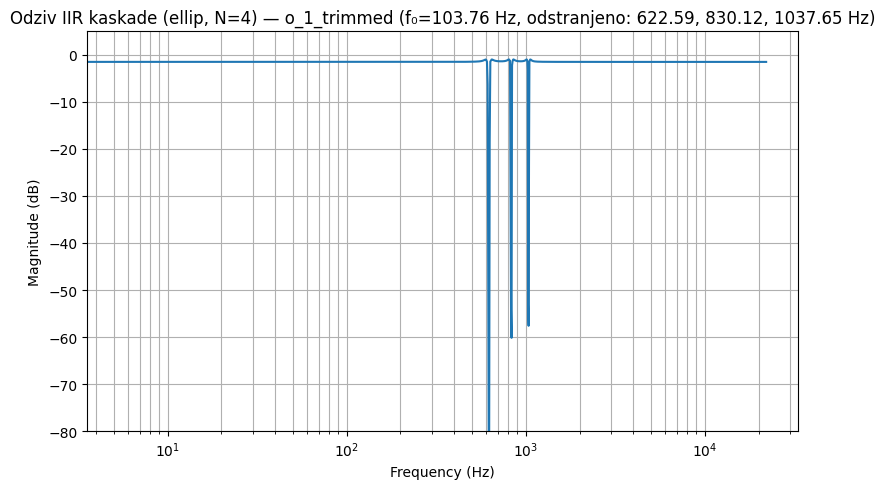

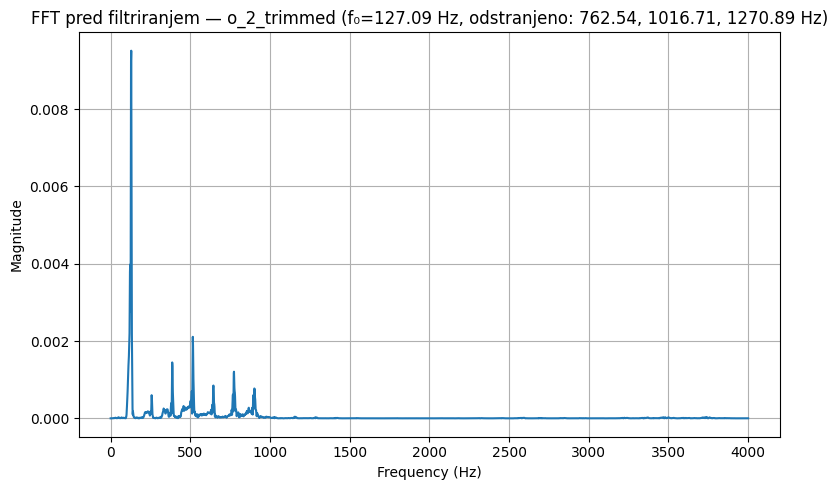

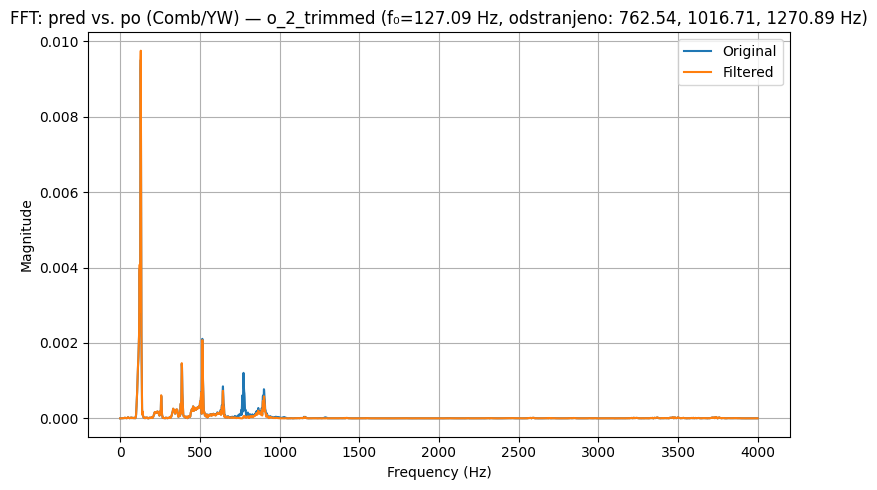

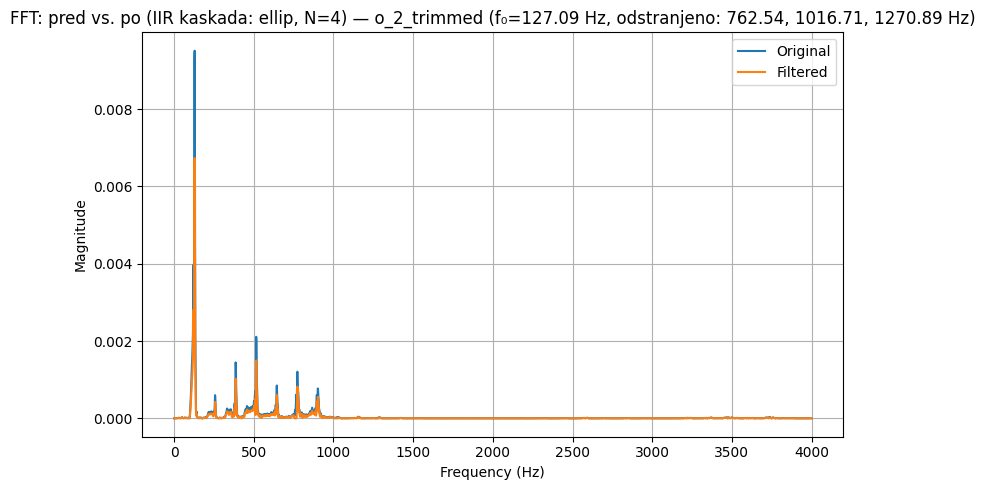

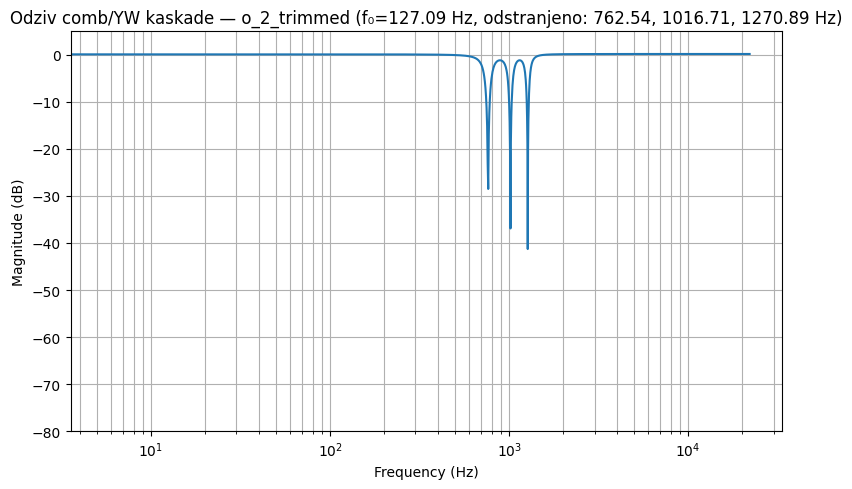

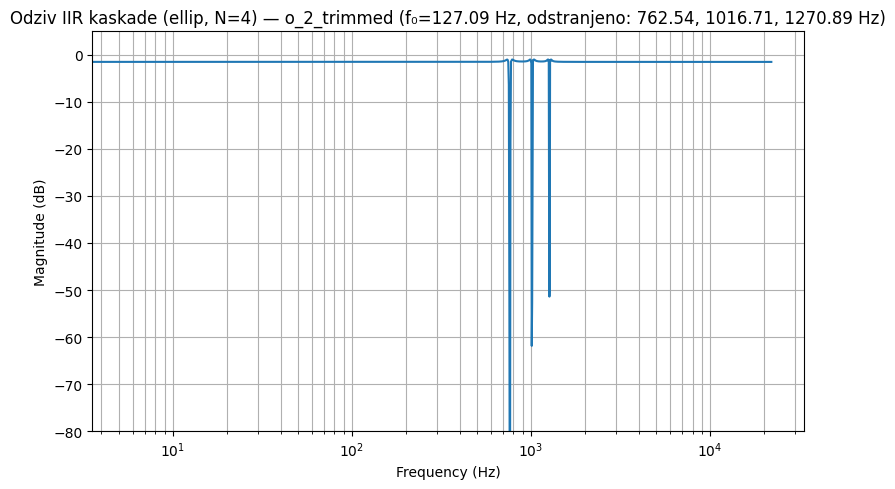

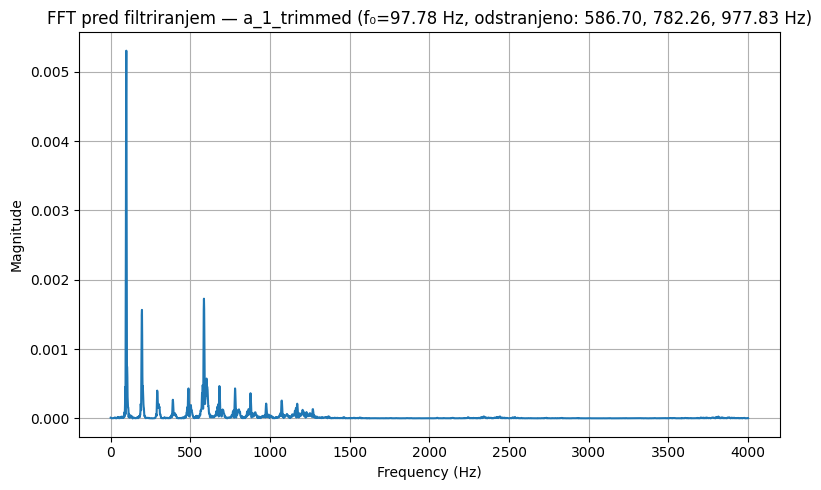

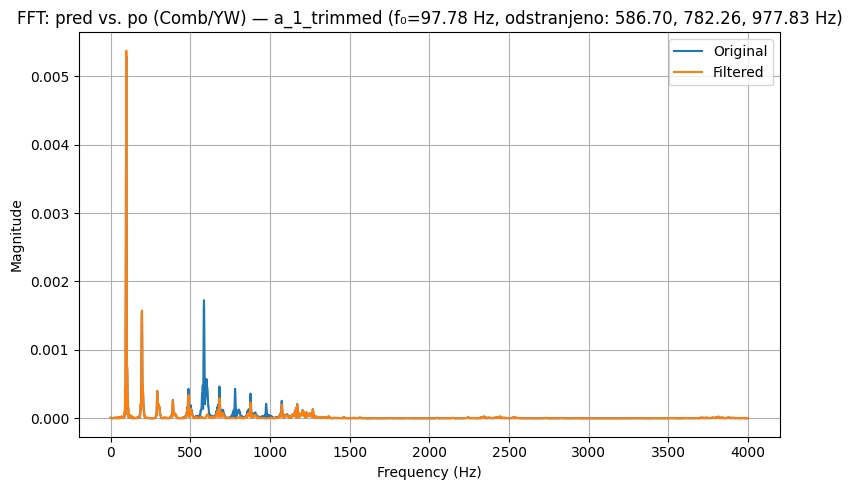

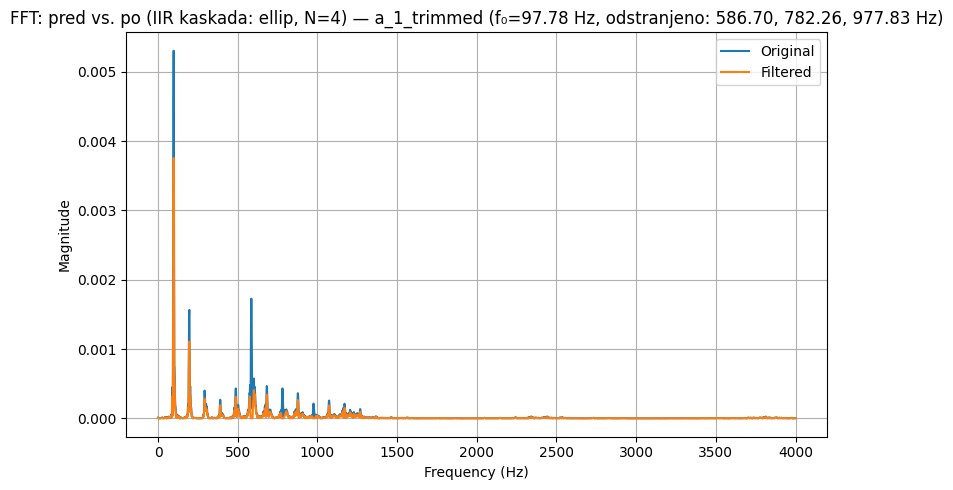

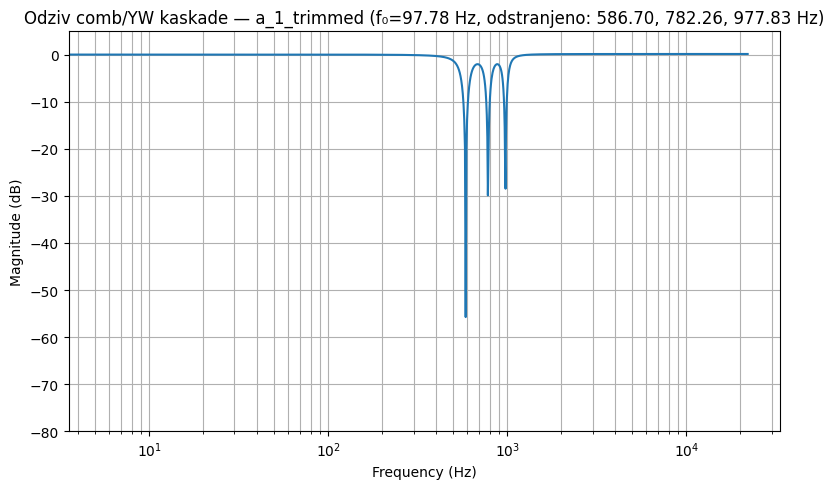

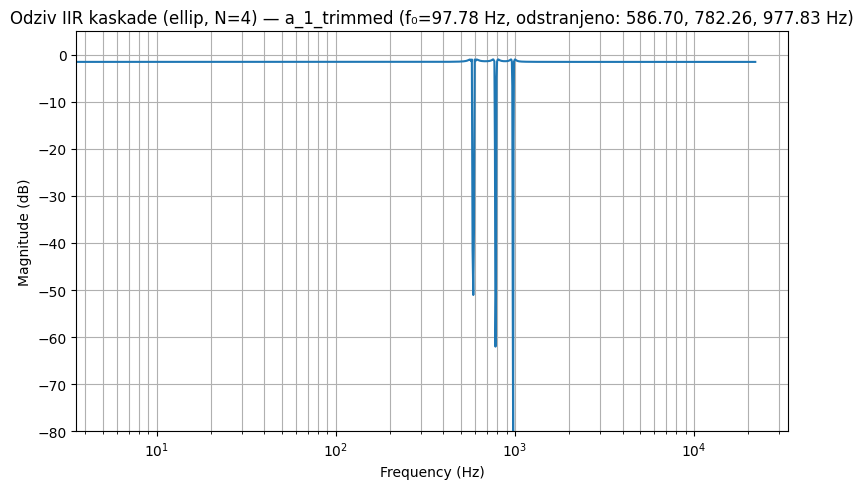

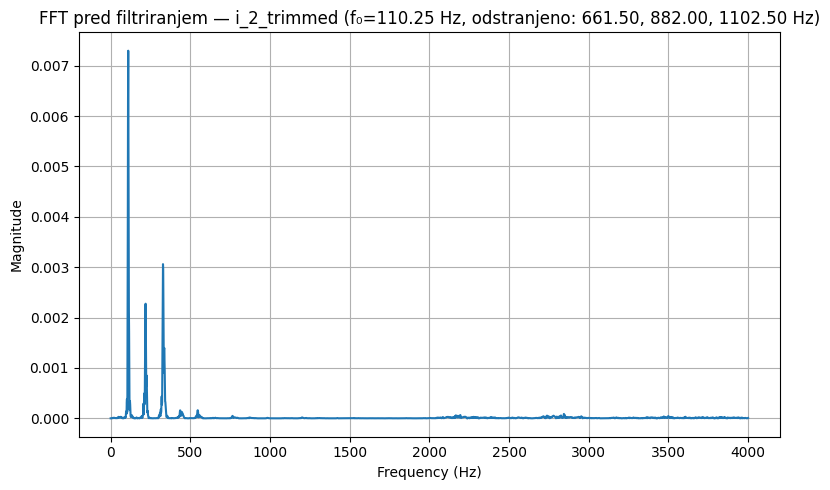

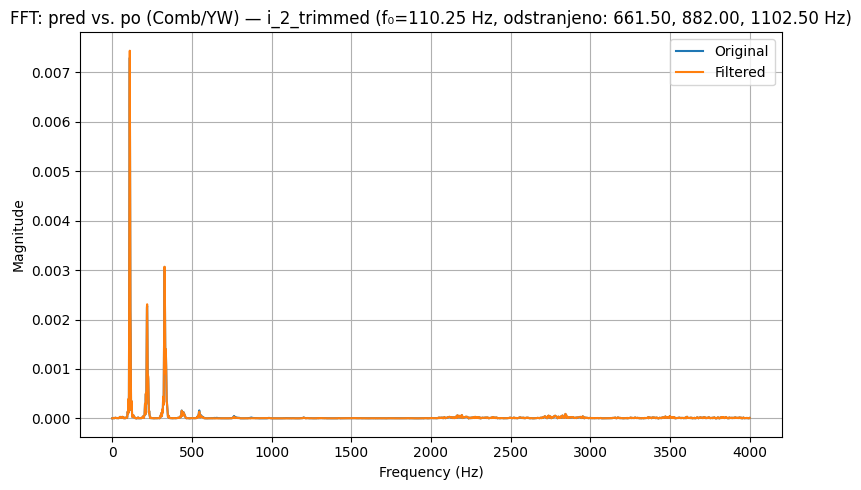

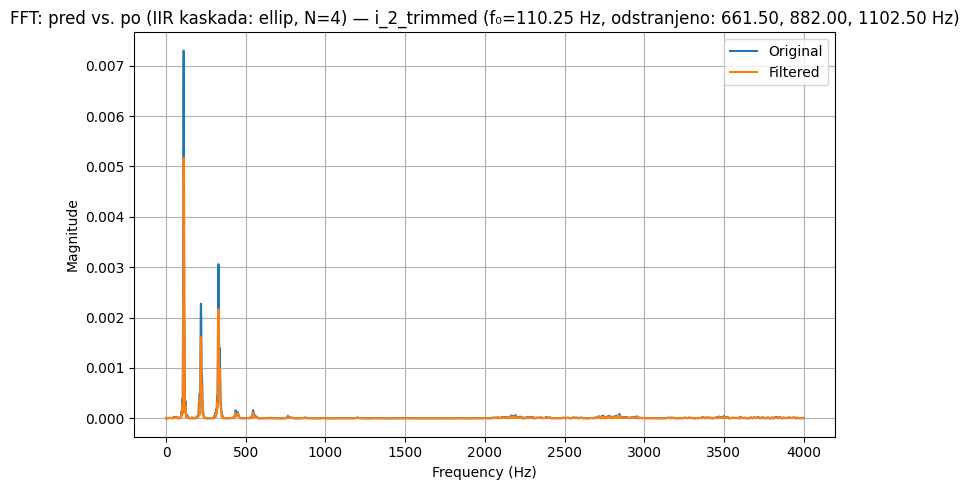

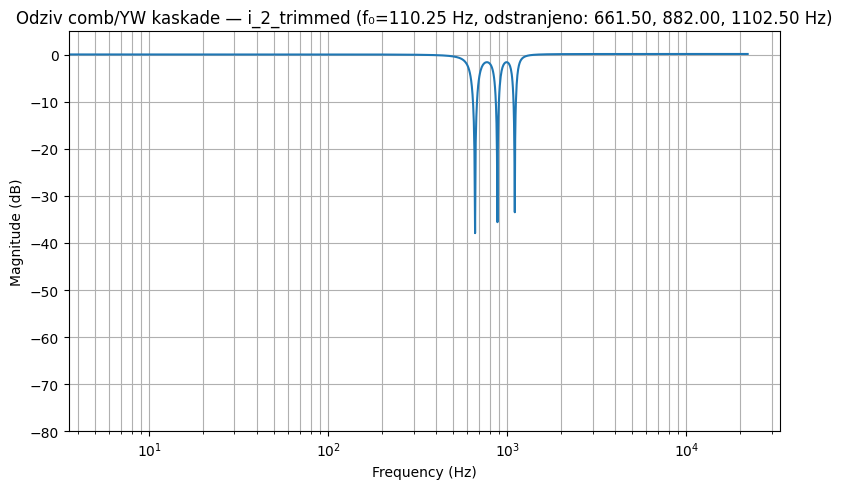

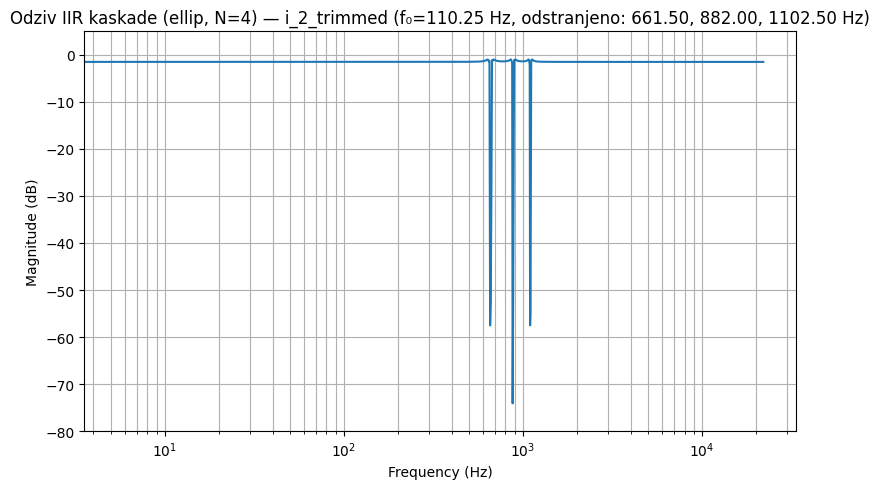

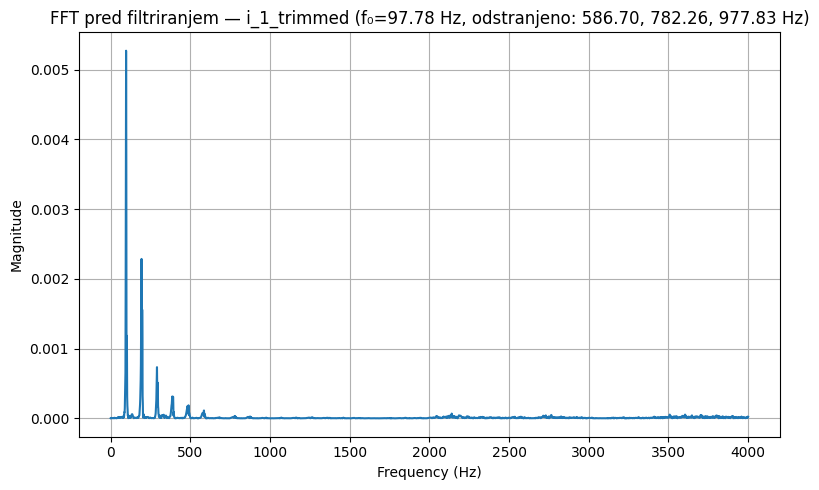

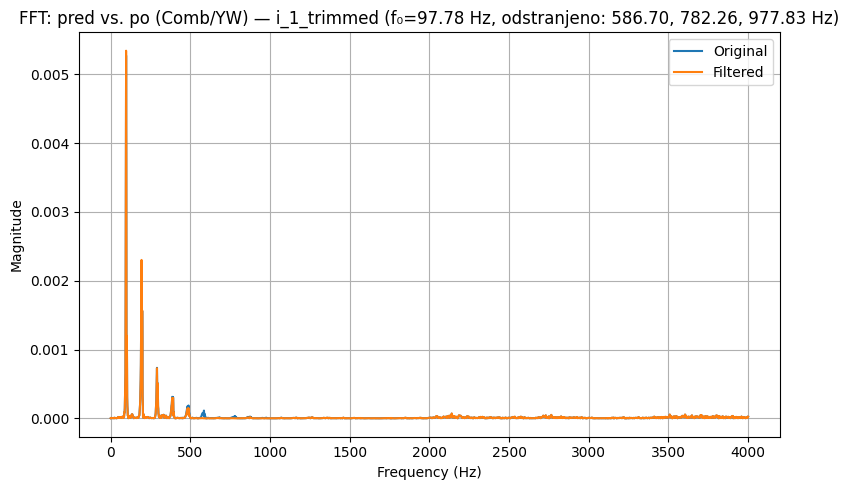

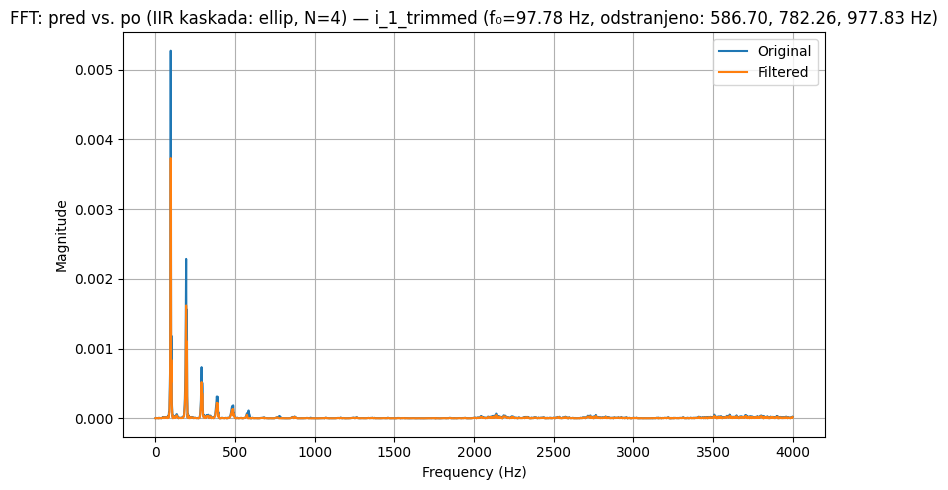

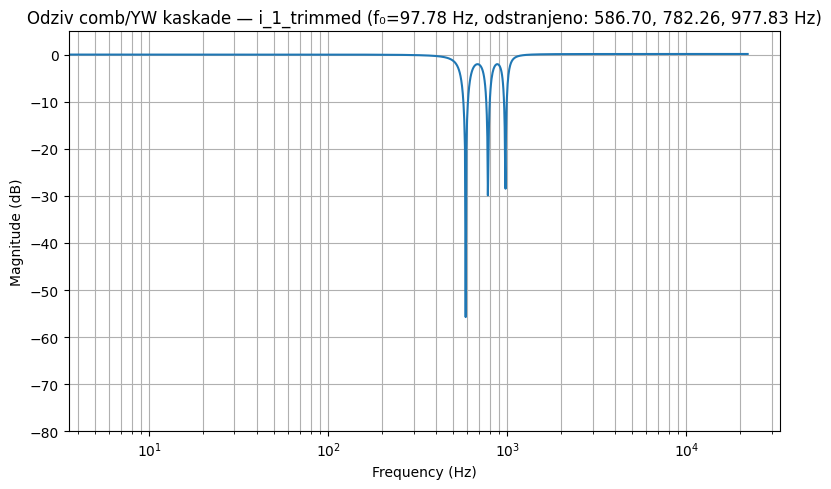

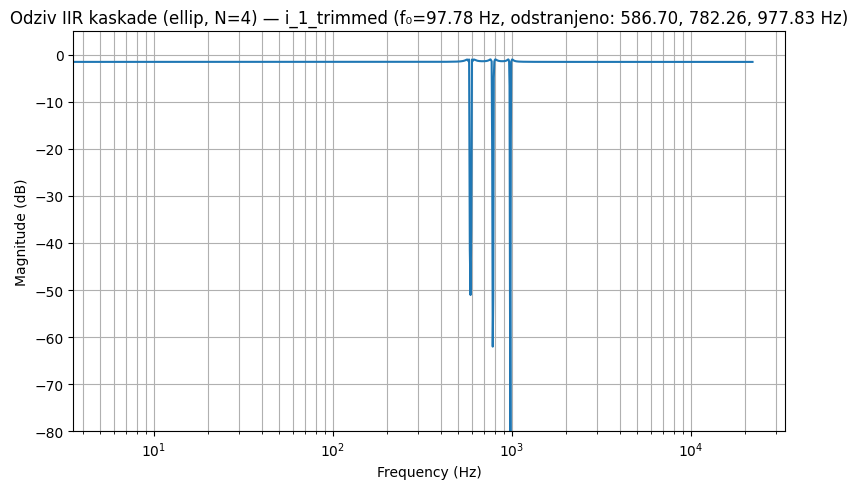

Končano. f0 vrednosti:
  a_2_trimmed: 114.84 Hz
  o_1_trimmed: 103.76 Hz
  o_2_trimmed: 127.09 Hz
  a_1_trimmed: 97.78 Hz
  i_2_trimmed: 110.25 Hz
  i_1_trimmed: 97.78 Hz


In [ ]:
# User-configurable parameters
harmonics_to_remove = [2, 3, 6, 8, 10]       # <- prilagodite po potrebi
f0_method = "autocorr"                # "autocorr" | "fft_peak" | "cepstrum" | "peaks"
manual_f0_hz = None                   # ali npr. 120.0 za ročno nastavitev

# Comb/YW
comb_bw_hz = 100.0                    # ±50 Hz -> total BW ~100 Hz

# IIR cascade
iir_family = "ellip"                  # "butter" | "cheby1" | "cheby2" | "ellip"
iir_order = 4                         # fiksni red na odsek
iir_half_bw_hz = 10.0                 # ±10 Hz
iir_rp = 0.5                          # (ellip/cheby1) ripple
iir_rs = 50.0                         # (ellip/cheby2/ellip) stopband attenuation

f0_log: Dict[str, float] = {}
run_log: Dict[str, dict] = {}

files = list_wavs(AUDIO_DIR)
if not files:
    warnings.warn("Ni WAV datotek v /audio_data.")

for path in files:
    name = os.path.splitext(os.path.basename(path))[0]
    fs, x = read_wav_mono(path)

    # f0
    f0 = estimate_f0(x, fs, method=f0_method, manual_f0_hz=manual_f0_hz)
    f0_log[name] = float(f0)

    # Design comb/YW cascade
    sos_comb = design_comb_cascade_sos(fs, f0, harmonics_to_remove, bw_hz=comb_bw_hz)
    w_c, H_c = freq_response_sos(sos_comb, fs)

    # Apply comb
    y_comb = apply_sos_zero_phase(x, sos_comb)

    # Design IIR cascade
    sos_iir = design_bandstop_cascade_sos_simple(fs, f0, harmonics_to_remove,
                                                 half_bw_hz=iir_half_bw_hz,order=iir_order)
    w_i, H_i = freq_response_sos(sos_iir, fs)

    # Apply IIR cascade
    y_iir = apply_sos_zero_phase(x, sos_iir)

    # --- Plots (FFT and responses)
    # Pre-calculate targeted harmonic freqs > 500 Hz
    target_freqs = [k * f0 for k in harmonics_to_remove if k * f0 > 500.0]
    target_str = ", ".join(f"{freq:.2f}" for freq in target_freqs)

    # --- Plots (FFT and responses)
    plot_fft(x, fs, f"FFT pred filtriranjem — {name} (f₀={f0:.2f} Hz, odstranjeno: {target_str} Hz)", fmax=min(4000, fs/2))
    overlay_fft(x, y_comb, fs, f"FFT: pred vs. po (Comb/YW) — {name} (f₀={f0:.2f} Hz, odstranjeno: {target_str} Hz)", fmax=min(4000, fs/2))
    overlay_fft(x, y_iir,  fs, f"FFT: pred vs. po (IIR kaskada: {iir_family}, N={iir_order}) — {name} (f₀={f0:.2f} Hz, odstranjeno: {target_str} Hz)", fmax=min(4000, fs/2))

    plot_filter_response(w_c, H_c, f"Odziv comb/YW kaskade — {name} (f₀={f0:.2f} Hz, odstranjeno: {target_str} Hz)")
    plot_filter_response(w_i, H_i, f"Odziv IIR kaskade ({iir_family}, N={iir_order}) — {name} (f₀={f0:.2f} Hz, odstranjeno: {target_str} Hz)")



    # Save audio
    out_comb = os.path.join(OUT_DIR, f"{name}_combYW.wav")
    out_iir  = os.path.join(OUT_DIR, f"{name}_iir_{iir_family}_N{iir_order}.wav")
    write_wav_int16(out_comb, fs, y_comb)
    write_wav_int16(out_iir,  fs, y_iir)

    # Log
    run_log[name] = {
        "f0_hz": float(f0),
        "harmonics": harmonics_to_remove,
        "comb_bw_hz": comb_bw_hz,
        "iir_family": iir_family,
        "iir_order": iir_order,
        "iir_half_bw_hz": iir_half_bw_hz,
        "iir_rp": iir_rp,
        "iir_rs": iir_rs,
        "fs": fs,
        "paths": {"in": path, "out_comb": out_comb, "out_iir": out_iir}
    }

# Save logs
with open(os.path.join(OUT_DIR, "f0_log.json"), "w", encoding="utf-8") as f:
    json.dump(f0_log, f, indent=2, ensure_ascii=False)
with open(os.path.join(OUT_DIR, "run_log.json"), "w", encoding="utf-8") as f:
    json.dump(run_log, f, indent=2, ensure_ascii=False)

print("Končano. f0 vrednosti:")
for k, v in f0_log.items():
    print(f"  {k}: {v:.2f} Hz")


### Vprašanje 1 — Kako je frekvenčna učinkovitost odvisna od **reda filtra**?

- Višji **red** ⇒ strmejši prehodi in večja **atenuacija** v zapornem pasu, a:
  - več koeficientov (več SOS), višja račun. zahtevnost in tveganje za numerično nestabilnost;
- Pri ozkih zaporah (±10 Hz) je pogosto dovolj **N=4** ali **N=6** za ~40–60 dB oslabitev harmonika.
- Spodaj je eksperiment, ki pokaže odvisnost atenuacije v točki `k∙f₀` od reda `N`.


Test file: a_2_trimmed  f0=114.84 Hz, harmonic=10 (f=1148.4 Hz)


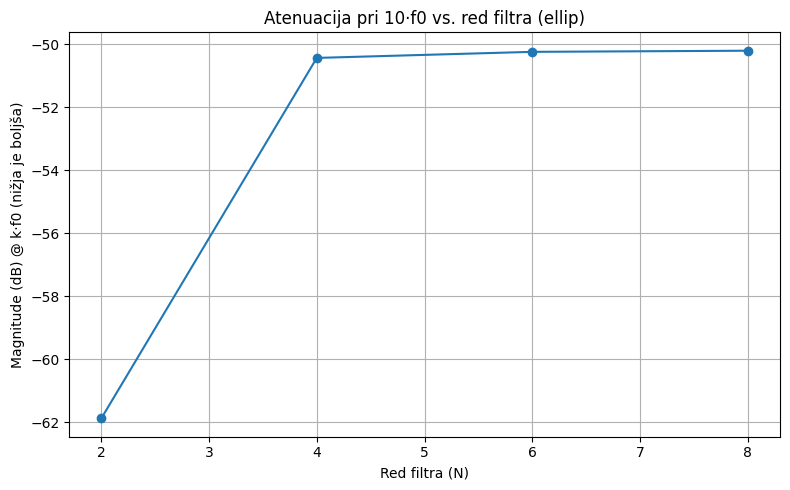

In [23]:
# Pick one file (first one) for a quick order sweep
if files:
    test_path = files[0]
    name = os.path.splitext(os.path.basename(test_path))[0]
    fs, x = read_wav_mono(test_path)
    f0 = estimate_f0(x, fs, method=f0_method, manual_f0_hz=manual_f0_hz)
    k = harmonics_to_remove[-1] if harmonics_to_remove else 2
    fH = k * f0
    print(f"Test file: {name}  f0={f0:.2f} Hz, harmonic={k} (f={fH:.1f} Hz)")

    orders = [2, 4, 6, 8]
    att_db = []

    for N in orders:
        sos = design_bandstop_cascade_sos_simple(fs, f0, [k], half_bw_hz=iir_half_bw_hz, order=N)
        w, H = freq_response_sos(sos, fs, worN=16384)

        idx = np.argmin(np.abs(w - fH))
        att_db.append(20*np.log10(np.maximum(np.abs(H[idx]), 1e-12)))

    plt.figure()
    plt.plot(orders, att_db, marker="o")
    plt.title(f"Atenuacija pri {k}·f0 vs. red filtra ({iir_family})")
    plt.xlabel("Red filtra (N)")
    plt.ylabel("Magnitude (dB) @ k·f0 (nižja je boljša)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### Vprašanje 2 — Zakaj **kaskada** filtrov?

- Vsak harmonik ima **lokalno** ozko zaporo ⇒ z **več ločenimi** odseki ciljno odstranimo točno želene frekvence.
- Prednost pred enim samim filtrom z več zaporami:
  - **Lažja kontrola** širine in globine vsake zapore,
  - **Stabilnost** in numerika (SOS, normalizirani segmenti)

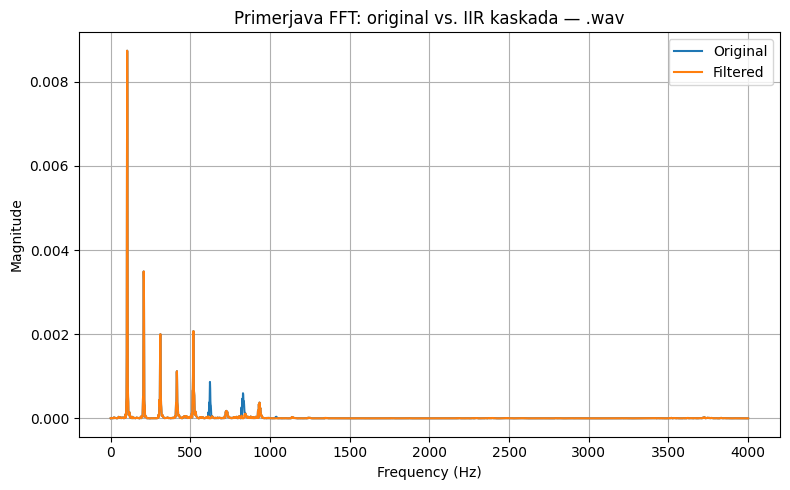

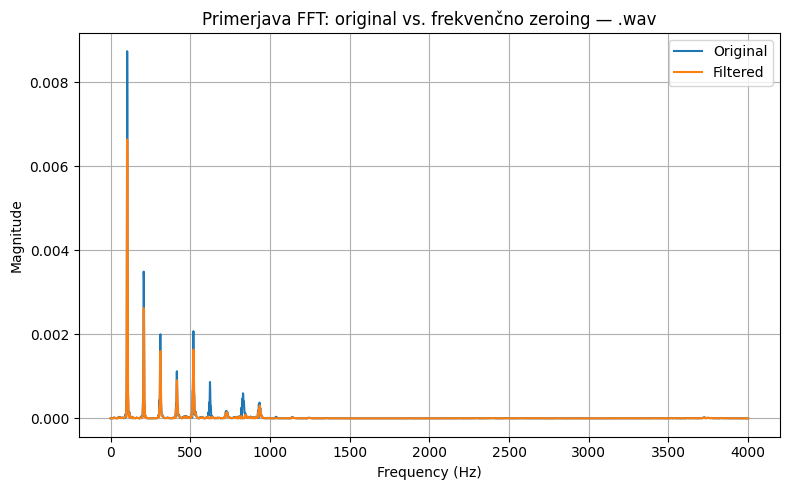

In [33]:
def freq_domain_notch(x: np.ndarray, fs: int, f0: float, harmonics: Iterable[int], half_bw_hz: float) -> np.ndarray:
    """
    Simple 'spectral zeroing': set FFT bins within ±half_bw around k*f0 to zero and IFFT back.
    """
    n = len(x)
    nfft = 1 << (n - 1).bit_length()
    X = np.fft.rfft(x * np.hanning(n), nfft)
    freqs = np.fft.rfftfreq(nfft, 1/fs)
    mask = np.ones_like(X, dtype=bool)
    for k in harmonics:
        fH = k * f0
        if fH <= 500.0:  # requirement
            continue
        m = (freqs >= (fH - half_bw_hz)) & (freqs <= (fH + half_bw_hz))
        mask[m] = False
    Xz = X.copy()
    Xz[~mask] = 0
    y = np.fft.irfft(Xz, nfft)[:n]
    # Scale back (remove window bias roughly)
    return y

# Quick comparison for the first file (if any)
if files:
    path = files[1]
    name = os.path.splitext(os.path.basename(path))[1]
    fs, x = read_wav_mono(path)
    f0 = estimate_f0(x, fs, method=f0_method, manual_f0_hz=manual_f0_hz)

    sos_iir = design_bandstop_cascade_sos_simple(fs, f0, harmonics_to_remove,
                                          half_bw_hz=iir_half_bw_hz, order=iir_order)
    y_iir = apply_sos_zero_phase(x, sos_iir)

    y_spec = freq_domain_notch(x, fs, f0, harmonics_to_remove, half_bw_hz=iir_half_bw_hz)

    overlay_fft(x, y_iir,  fs, f"Primerjava FFT: original vs. IIR kaskada — {name}", fmax=min(4000, fs/2))
    overlay_fft(x, y_spec, fs, f"Primerjava FFT: original vs. frekvenčno zeroing — {name}", fmax=min(4000, fs/2))


### Vprašanje 3 — Kaskada IIR vs. filtriranje v frekvenčnem prostoru

- **IIR kaskada (časovna domena)**:
  - zelo **natančna** ozka zapora (±10 Hz), **kontinuirna** obdelava (streaming),
  - **stabilnost** z uporabo SOS in `filtfilt` (brez fazne distorzije),
  - možno realnočasovno delovanje brez FFT overhead-a (z `sosfilt`).
- **Frekvenčno zeroing (FFT/IFFT)**:
  - enostavno za “off-line”, a odrez binov je vezan na **ločljivost FFT**,
  - lahko povzroči **zvonjenje** (sinc sidelobes) in artefakte, če izrežemo preozko,
  - ni naravno primerno za **real-time**.
  
**Sklep:** Kaskada IIR omogoča finejšo, stabilno in časovno učinkovito odstranitev višjih harmonikov, še posebej pri ozkih pasovih in realnočasovni obdelavi. Frekvenčno zeroing je uporabno za hitro analizo/retušo, vendar je manj nadzorovano in lahko uvaja artefakte.
